In [13]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.filters import threshold_otsu

import importlib
import sys

sys.path.append('C:\\Users\\marcu\\OneDrive\\Desktop\\PraktikumIII\\CapillaryRiseInSoil\\notebooks')

import amglib.imageutils as amg
import amglib.readers as rd
import amglib.bb as bb

import os

os.chdir('C:\\Users\\marcu\\OneDrive\\Desktop\\PraktikumIII\\CapillaryRiseInSoil')

import pandas as pd
import datetime 

from scipy.optimize import curve_fit

In [14]:
ts2 = rd.readImages('data/02_rawdata/Sand/2/2_{0:05d}.fits',first=1,last=120).astype(float)
timestamps=rd.read_fits_meta_data2('data/02_rawdata/Sand/2/2_{0:05d}.fits',first=1,last=120, parlist=['FRAME'])

  0%|          | 0/119 [00:00<?, ?it/s]

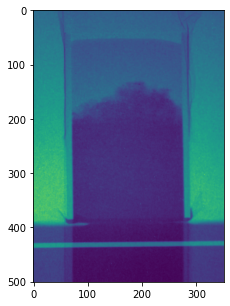

In [15]:
plt.figure(figsize=(7,5))
plt.imshow(ts2[50][::-1]) # added a flip -> originally we looked at ts2[50]
# plt.grid()

In [23]:
plt.imshow(ts2[30:80,::-1, 150].transpose(),aspect='auto', interpolation='none') # MM COMMENT -> Maybe 44:80??
plt.xlabel('time')
plt.ylabel('height');
plt.colorbar()

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

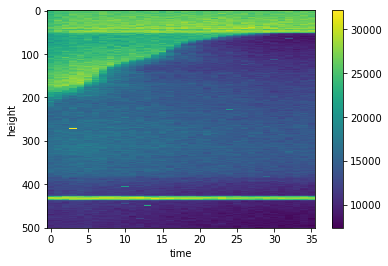

In [5]:
plt.imshow(ts2[44:80,::-1, 150].transpose(),aspect='auto', interpolation='none') # MM COMMENT -> Maybe 44:80??
plt.xlabel('time')
plt.ylabel('height');
plt.colorbar()

###### Remove black part ? 

In [6]:
tslice= ts2[44:80,::-1,150].transpose() # -> 44 to remove big black thinkg

In [7]:
np.mean(tslice) / np.std(tslice, ddof=1)

2.9049950289764266

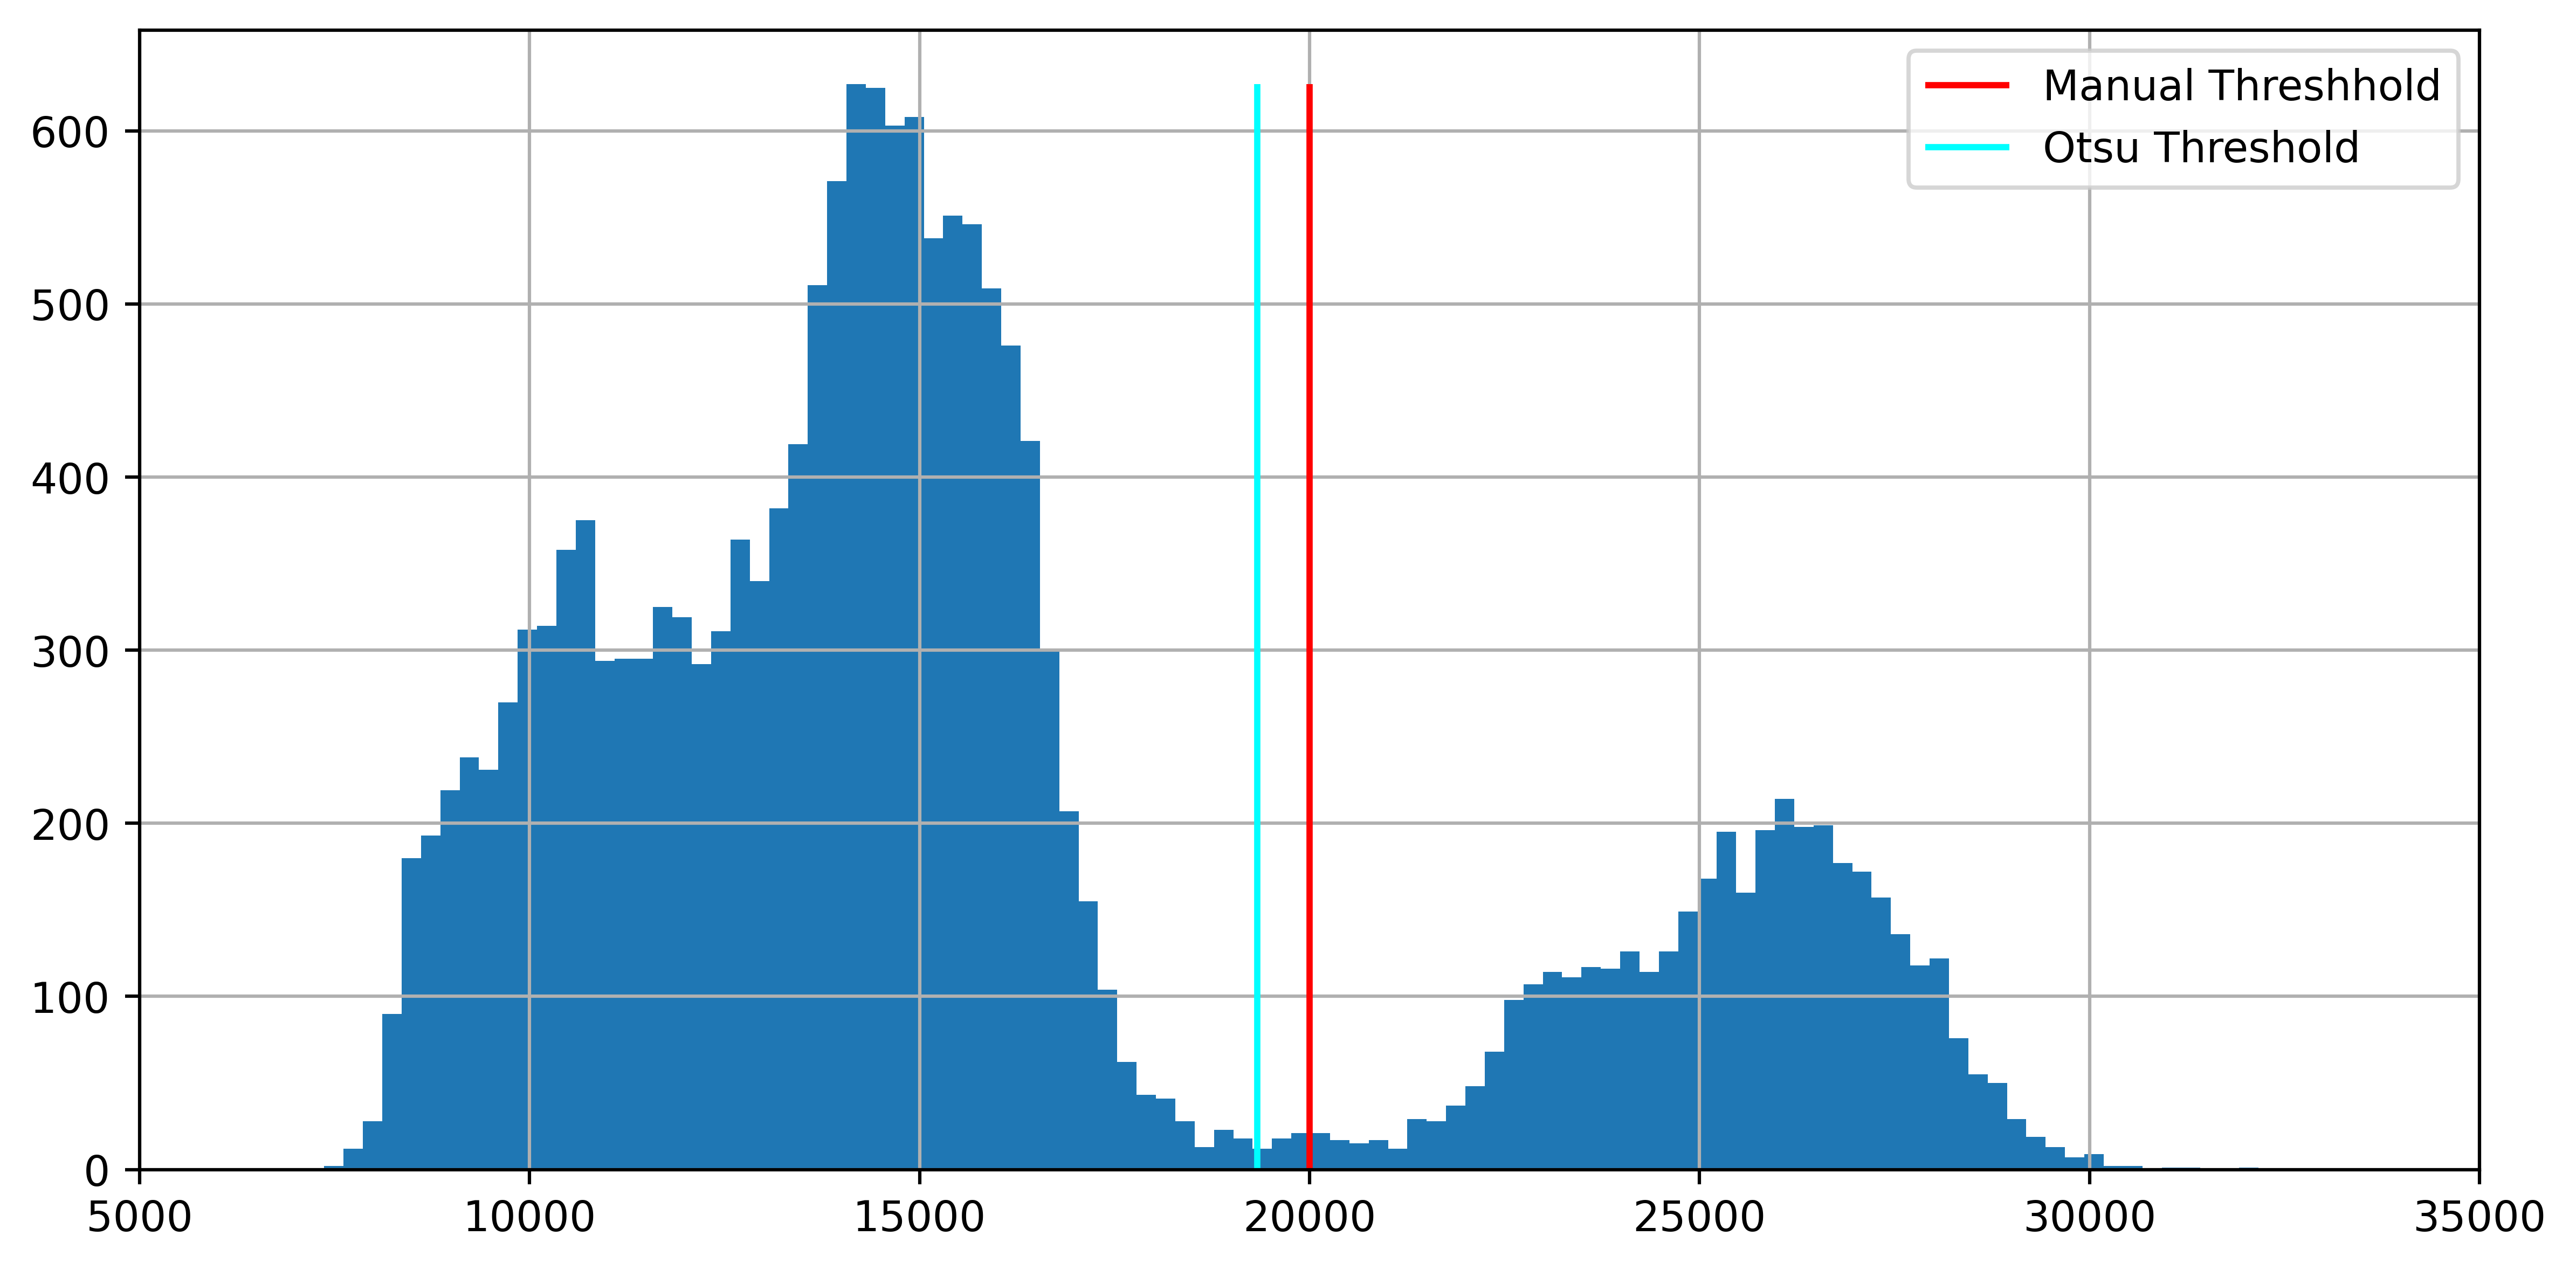

In [73]:
plt.figure(dpi=560, figsize=(10,5))
bin_fills = plt.hist(tslice.ravel(), bins=100)[0]
plt.vlines([20000],ymax=bin_fills.max(),ymin=0,color='red', label = "Manual Threshhold")
plt.vlines([threshold_otsu(tslice)],ymax=bin_fills.max(),ymin=0,color='cyan', label = "Otsu Threshold")
plt.grid()
plt.xlim(5000, 35000)
plt.legend()

In [74]:
threshold_otsu(tslice)

19330.580078125

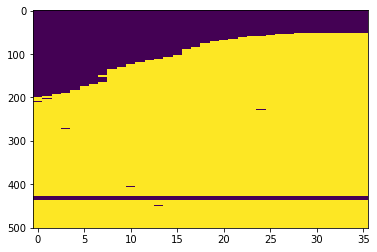

In [75]:
plt.imshow(tslice<20000,aspect='auto',interpolation='none')

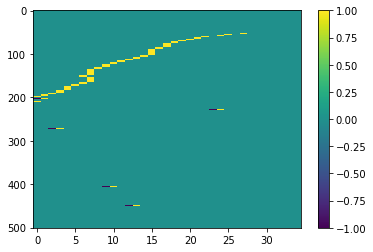

In [76]:
bts=tslice<20000
plt.imshow(bts[:,1:].astype(float)-bts[:,:-1].astype(float),aspect='auto',interpolation='none')
plt.colorbar()

In [77]:
dts=bts[:,1:].astype(float)-bts[:,:-1].astype(float)
points=np.where(0<dts)

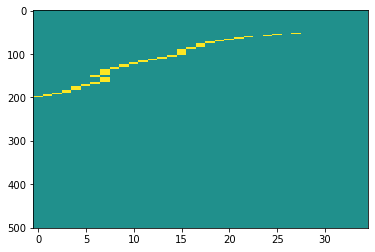

In [78]:
# remove outliers
dts[200:500, :] = 0
plt.imshow(dts, aspect='auto',interpolation='none')

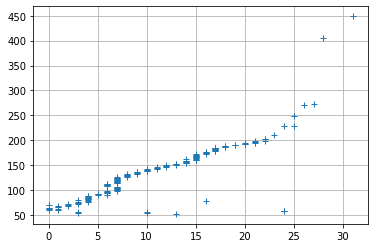

In [123]:
plt.plot(points[1], np.flip((points[0])),'+')
plt.grid()

In [124]:
cutoff = -9

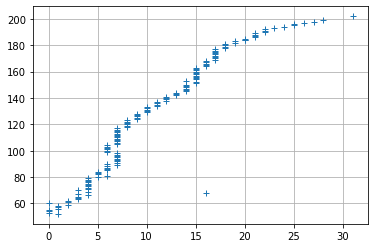

In [125]:
plt.plot(points[1][:cutoff], np.flip(points[0][:cutoff]),'+')
plt.grid()

##### TIME 

In [82]:
timestamps_s = np.zeros((len(timestamps['FRAME']), 2))
for i in range(len(timestamps['FRAME'])):
    s=timestamps['FRAME'][i][-2:]
    m=timestamps['FRAME'][i][-5:-3]
    timestamps_s[i] = (m, s)
time_array = timestamps_s[:,0] * 60 + timestamps_s[:,1];
time_array = pd.to_timedelta(time_array, unit='second');

In [83]:
# time_array[44], time_array[60], time_array[80]
time_array = time_array[44:81] 

In [84]:
time_array

TimedeltaIndex(['0 days 00:08:00', '0 days 00:08:03', '0 days 00:08:05',
                '0 days 00:08:07', '0 days 00:08:10', '0 days 00:08:12',
                '0 days 00:08:14', '0 days 00:08:17', '0 days 00:08:19',
                '0 days 00:08:21', '0 days 00:08:24', '0 days 00:08:26',
                '0 days 00:08:29', '0 days 00:08:31', '0 days 00:08:33',
                '0 days 00:08:36', '0 days 00:08:38', '0 days 00:08:40',
                '0 days 00:08:43', '0 days 00:08:45', '0 days 00:08:47',
                '0 days 00:08:50', '0 days 00:08:52', '0 days 00:08:55',
                '0 days 00:08:57', '0 days 00:08:59', '0 days 00:09:02',
                '0 days 00:09:04', '0 days 00:09:06', '0 days 00:09:09',
                '0 days 00:09:11', '0 days 00:09:13', '0 days 00:09:16',
                '0 days 00:09:18', '0 days 00:09:20', '0 days 00:09:23',
                '0 days 00:09:25'],
               dtype='timedelta64[ns]', freq=None)

In [85]:
# np.unique(points[1][:cutoff])

In [86]:
time_array[np.unique(points[1][:cutoff])] 
time_array[np.unique(points[1][:cutoff])] - time_array[0] # normalized to time 0 being the first image
time_delta_array = time_array[np.unique(points[1][:cutoff])] - time_array[0]

In [87]:
@np.vectorize
def convert_timedelta_to_second_int(val):
    return val.total_seconds()

subs = {k:v for v,k in zip(time_delta_array, np.unique(points[1][:cutoff]))}
new_time_array = np.array([subs.get(item,item) for item in points[1][:cutoff]])
new_time_array = convert_timedelta_to_second_int(new_time_array)

##### PX 

In [88]:
px_per_centimeter = 1578.0713/14 # px / cm
centimeter_per_pixel = px_per_centimeter**(-1)

In [89]:
cm_height = centimeter_per_pixel * np.flip(points[0][:cutoff]) * 2 # cm * px^-1 * px = cm, *2 because of binning

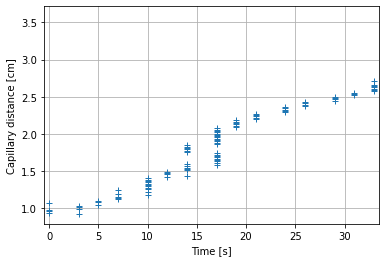

In [90]:
plt.figure()
plt.plot(new_time_array, cm_height, '+')
plt.xlabel("Time [s]")
plt.ylabel("Capillary distance [cm]")
plt.xlim(-0.5,33.5)
plt.grid()

In [91]:
def srqt_analysis(t, a, b): # a = np.sqrt(c) c a collection of constants
    return a*np.sqrt(t)+b

height = cm_height # cm

time = new_time_array # s

popt, pcov = curve_fit(srqt_analysis, time, height, p0=[2.5, 0.1])

constants_sqrt, displacement = popt
new_model = lambda t: constants_sqrt * np.sqrt(t) + displacement   # cm = sqrt(...) * sqrt(time) -> constant has units m/time
time_linspace = np.linspace(0,35,100)

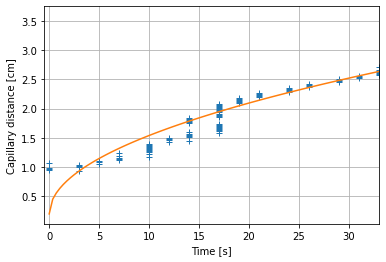

In [92]:
plt.figure()
plt.plot(new_time_array, cm_height, '+')
plt.plot(time_linspace, new_model(time_linspace))
plt.xlabel("Time [s]")
plt.ylabel("Capillary distance [cm]")
plt.xlim(-0.5,33)
plt.grid()

##### Means 

In [149]:
points_new = ((points[0][:cutoff])[::-1], points[1][:cutoff])
means_std = np.zeros((len(np.unique(points_new[1])), 2))
maxima = np.zeros(len(np.unique(points_new[1])))

In [150]:
for (tmp, i) in enumerate(np.unique(points_new[1])):
    indices = np.where(points_new[1] == i)
    relevant_points = points_new[0][indices]
    
    means_std[tmp] = (relevant_points.mean(), relevant_points.std(ddof=1))
    maxima[tmp] = relevant_points.max()

means_std[:, 1][-7:] = np.mean(means_std[:,1][:-7]) / 2
means_stdcm = np.array([means_std[:, 0] * centimeter_per_pixel * 2, means_std[:,1] * centimeter_per_pixel * 2])

maxima_w_error = np.array([maxima * centimeter_per_pixel * 2, maxima*centimeter_per_pixel*2/14])

##### Usable plots 

In [151]:
np.unique(new_time_array)

array([ 0.,  3.,  5.,  7., 10., 12., 14., 17., 19., 21., 24., 26., 29.,
       31., 33., 36., 38., 40., 43., 45., 47., 50., 52., 55., 57., 59.,
       62., 64., 66., 73.])

In [152]:
means_stdcm

array([[0.98474638, 0.98918217, 1.07641947, 1.16750111, 1.30654311,
        1.45937639, 1.66490154, 1.84529051, 2.13805295, 2.23564043,
        2.32435632, 2.40420062, 2.47517333, 2.53727446, 2.63105983,
        2.79159334, 2.65556231, 3.0695698 , 3.18490045, 3.23812999,
        3.27065915, 3.32684588, 3.388947  , 3.42443336, 3.44217654,
        3.4687913 , 3.49540607, 3.51314925, 3.53089243, 3.58412196],
       [0.05516578, 0.04666377, 0.02710315, 0.04923532, 0.07020235,
        0.03030225, 0.14841794, 0.16463455, 0.03319445, 0.02805443,
        0.02805443, 0.02290634, 0.02290634, 0.01774318, 0.04773573,
        0.06864958, 0.71031831, 0.04859169, 0.02290634, 0.01254632,
        0.01024403, 0.02290634, 0.01774318, 0.03709187, 0.03709187,
        0.03709187, 0.03709187, 0.03709187, 0.03709187, 0.03709187]])

Mean:  [0.43712707 0.20621374]
Maximum: [0.36249469 0.53744126]


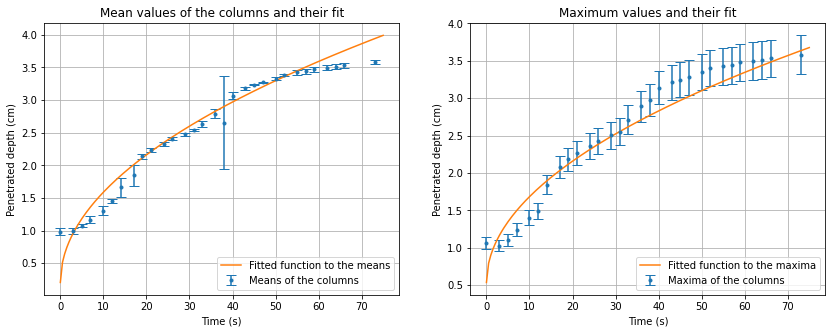

In [166]:
def sqrt_analysis(t, a, b): # a = np.sqrt(c) c a collection of constants
    return a*np.sqrt(t)+b

fig, ax = plt.subplots(1, 2, figsize=[14, 5])
ax = ax.ravel()

ax[0].set_title("Mean values of the columns and their fit")
ax[0].errorbar(np.unique(new_time_array), means_stdcm[0], yerr=means_stdcm[1], capsize=5, marker = '.', linestyle="", label="Means of the columns")

popt, pcov = curve_fit(sqrt_analysis, np.unique(new_time_array), means_stdcm[0], sigma = means_stdcm[1]) 
print("Mean: ", popt)
new_model = lambda x: popt[0] * np.sqrt(x) + popt[1] 
χsq_mean = ( (means_stdcm[0] - new_model(np.unique(new_time_array)) )**2 / means_stdcm[1]**2 ) 
new_linsp = np.linspace(0, 75, 150)

ax[0].plot(new_linsp, new_model(new_linsp), label = "Fitted function to the means")
ax[0].legend(loc="lower right")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Penetrated depth (cm)")

ax[1].set_title("Maximum values and their fit")
ax[1].errorbar(np.unique(new_time_array), maxima_w_error[0], yerr=maxima_w_error[1], capsize=5, marker = '.', linestyle="", label="Maxima of the columns")

popt, pcov = curve_fit(sqrt_analysis, np.unique(new_time_array), maxima_w_error[0], sigma = maxima_w_error[1], p0=[0.49, 0.45]) 
print("Maximum:", popt)
new_model_max = lambda x: popt[0] * np.sqrt(x) + popt[1] 
χsq_max = ( (maxima_w_error[0] - new_model_max(np.unique(new_time_array)) )**2 / maxima_w_error[1]**2 ) 
new_linsp = np.linspace(0, 75, 150)

ax[1].plot(new_linsp, new_model(new_linsp), label = "Fitted function to the maxima")
ax[1].legend(loc="lower right")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Penetrated depth (cm)")

for axis in ax:
    axis.grid()

In [180]:
print("Average χ^2: ", sum(χsq_mean), "reduced: ", sum(χsq_mean)/(len(χsq_mean) - 2))

Average χ^2:  701.1518328398495 reduced:  25.04113688713748


In [178]:
print("Max χ^2: ", sum(χsq_max), "reduced: ", sum(χsq_max)/(len(χsq_max)-2))

Max χ^2:  98.72892982120348 reduced:  3.526033207900124


In [176]:
np.mean(maxima_w_error[0])

2.6082471685531567

In [132]:
means_stdcm

array([[0.98474638, 0.98918217, 1.07641947, 1.16750111, 1.30654311,
        1.45937639, 1.66490154, 1.84529051, 2.13805295, 2.23564043,
        2.32435632, 2.40420062, 2.47517333, 2.53727446, 2.63105983,
        2.79159334, 2.65556231, 3.0695698 , 3.18490045, 3.23812999,
        3.27065915, 3.32684588, 3.388947  , 3.42443336, 3.44217654,
        3.4687913 , 3.49540607, 3.51314925, 3.53089243, 3.58412196],
       [0.05516578, 0.04666377, 0.02710315, 0.04923532, 0.07020235,
        0.03030225, 0.14841794, 0.16463455, 0.03319445, 0.02805443,
        0.02805443, 0.02290634, 0.02290634, 0.01774318, 0.04773573,
        0.06864958, 0.71031831, 0.04859169, 0.02290634, 0.01254632,
        0.01024403, 0.02290634, 0.01774318, 0.03709187, 0.03709187,
        0.03709187, 0.03709187, 0.03709187, 0.03709187, 0.03709187]])

In [133]:
maxima_w_error

array([[1.06459068, 1.02910433, 1.10007704, 1.24202246, 1.40171106,
        1.49042695, 1.84529051, 2.07595183, 2.1824109 , 2.27112679,
        2.35984268, 2.43081539, 2.5017881 , 2.55501763, 2.71470624,
        2.89213802, 2.98085391, 3.14054251, 3.21151522, 3.24700158,
        3.28248793, 3.35346065, 3.40669018, 3.42443336, 3.44217654,
        3.47766289, 3.49540607, 3.51314925, 3.53089243, 3.58412196],
       [0.07604219, 0.07350745, 0.07857693, 0.08871589, 0.10012222,
        0.10645907, 0.13180647, 0.14828227, 0.15588649, 0.16222334,
        0.16856019, 0.17362967, 0.17869915, 0.18250126, 0.19390759,
        0.20658129, 0.21291814, 0.22432446, 0.22939394, 0.23192868,
        0.23446342, 0.2395329 , 0.24333501, 0.24460238, 0.24586975,
        0.24840449, 0.24967186, 0.25093923, 0.2522066 , 0.25600871]])